In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential 


%matplotlib inline

In [2]:
np.random.seed(13)

# 1. A Single Layer Network on the Hitters Data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV

In [4]:
hitters = sm.datasets.get_rdataset('Hitters', 'ISLR').data.dropna().reset_index(drop=True)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [5]:
nrows = hitters.shape[0]
test_id = np.random.choice(nrows, nrows // 3, replace=False)
train_id = hitters.index.difference(test_id)

In [6]:
lfit = smf.ols('Salary ~ ' + '+'.join(hitters.columns.drop('Salary')), 
               data=hitters, subset=train_id).fit()

In [7]:
mean_absolute_error(
    hitters.loc[test_id, 'Salary'], 
    lfit.predict(hitters.drop(columns='Salary').loc[test_id])
)

242.99282793560923

In [8]:
preprocess = ColumnTransformer([
    ('encode', OneHotEncoder(), hitters.select_dtypes('object').columns),
    ('scale', StandardScaler(), hitters.select_dtypes('number').drop(columns='Salary').columns)
])

In [9]:
X = preprocess.fit_transform(hitters.drop(columns='Salary'))
y = hitters['Salary'].copy()

In [10]:
X_train = X[train_id]
X_test = X[test_id]
y_train = y[train_id]
y_test = y[test_id]

In [11]:
lasso = LassoCV(cv=10, random_state=13).fit(X_train, y_train)

In [12]:
mean_absolute_error(y_test, lasso.predict(X_test))

219.88804382063952

In [13]:
model = Sequential([
    Dense(units=50, activation='relu', input_shape=(X_train.shape[1], )),
    Dropout(rate=0.4),
    Dense(units=1)
])

In [14]:
model.compile(
    tf.keras.optimizers.RMSprop(), 
    tf.keras.losses.MeanSquaredError(),
    [tf.keras.metrics.MeanAbsoluteError(), ]
)

In [15]:
history = model.fit(
    X_train, y_train, epochs=1500, batch_size=32, 
    validation_data=(X_test, y_test), verbose=0
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1150      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
mean_absolute_error(y_test, model.predict(X_test))

3/3 [==============================] - 0s 3ms/step


225.43696503948343

In [17]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

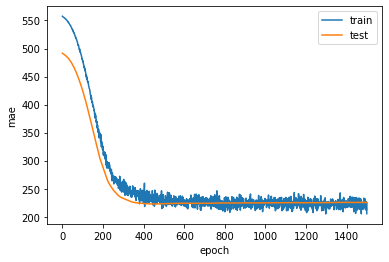

In [18]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='test')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend()

# 2. A Multilayer Network on the MNIST Digit Data

In [19]:
mnist = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [20]:
(X_train, y_train), (X_test, y_test) = mnist

In [21]:
X_train.shape

(60000, 28, 28)

In [22]:
X_test.shape

(10000, 28, 28)

In [23]:
y_train.shape

(60000,)

In [24]:
y_test.shape

(10000,)

In [25]:
X_train = X_train.reshape((60000, 28*28))
X_test = X_test.reshape((10000, 28*28))

In [26]:
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [27]:
X_train = X_train / 255
X_test = X_test / 255

In [28]:
model = Sequential([
    Dense(units=256, activation='relu', input_shape=(784, )),
    Dropout(rate=0.4),
    Dense(units=128, activation='relu'),
    Dropout(rate=0.3),
    Dense(units=10, activation='softmax')
])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy()]
)

In [31]:
history = model.fit(X_train, y_train, epochs=30, batch_size=128,
                    validation_split=0.2, verbose=0)

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epochs')]

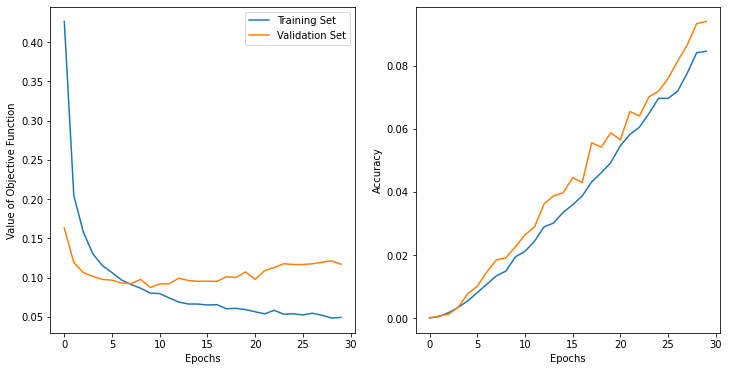

In [33]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 6))

ax[0].plot(history.history['loss'], label='Training Set')
ax[0].plot(history.history['val_loss'], label='Validation Set')
ax[0].legend()
ax[0].set(xlabel='Epochs', ylabel='Value of Objective Function')

ax[1].plot(np.array(history.history['accuracy']))
ax[1].plot(np.array(history.history['val_accuracy']))
ax[1].set(xlabel='Epochs', ylabel='Accuracy')

In [34]:
(model.predict(X_test).argmax(axis=1) == y_test.argmax(axis=1)).mean()

313/313 [==============================] - 1s 1ms/step


0.981

In [35]:
model_logit = Sequential([
    Dense(units=10, activation='softmax', input_shape=(784, ))
])

model_logit.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_logit.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy(),]
)

model_logit.fit(X_train, y_train, 
                batch_size=128, epochs=30, 
                validation_split=0.2, verbose=0)

(model_logit.predict(X_test).argmax(axis=1) == y_test.argmax(axis=1)).mean()

313/313 [==============================] - 0s 1ms/step


0.927

# 3. Convolutional Neural Networks

In [37]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

In [38]:
cifair100 = tf.keras.datasets.cifar100.load_data()

169001437/169001437 [==============================] - 13s 0us/step


In [39]:
(X_train, y_train), (X_test, y_test) = cifair100

In [40]:
X_train.shape

(50000, 32, 32, 3)

In [41]:
X_test.shape

(10000, 32, 32, 3)

In [42]:
y_train.shape

(50000, 1)

In [43]:
y_test.shape

(10000, 1)

In [44]:
X_train.min(), X_train.max()

(0, 255)

In [45]:
X_train = X_train / 255
X_test = X_test / 255

In [46]:
y_train = pd.get_dummies(y_train.squeeze()).values
y_test = pd.get_dummies(y_test.squeeze()).values

In [47]:
y_train.shape

(50000, 100)

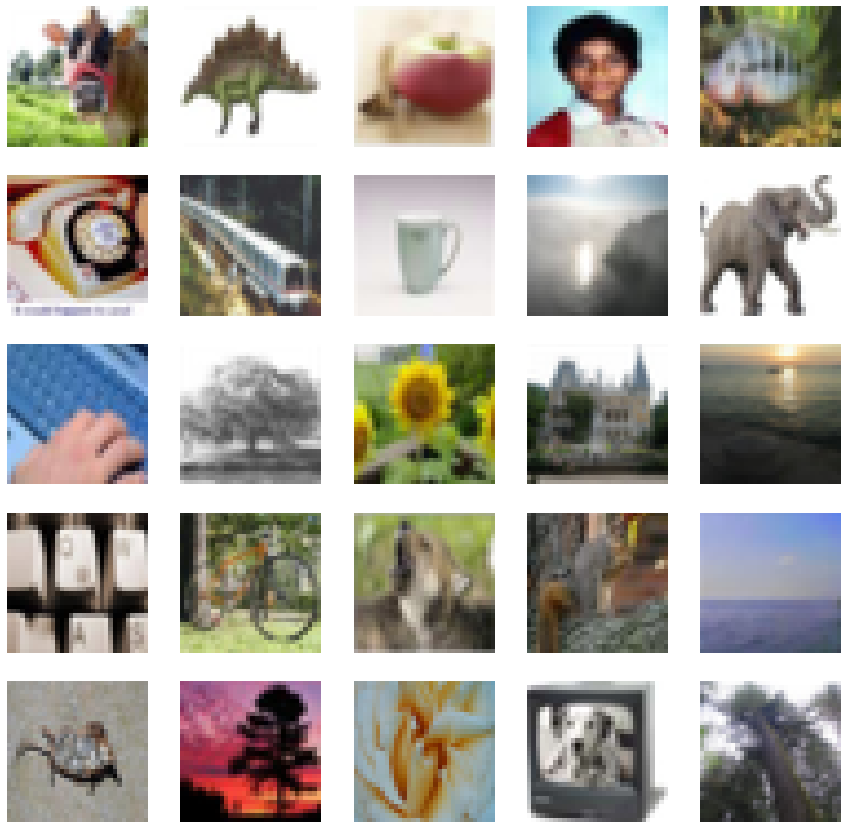

In [48]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.imshow(X_train[i])

In [49]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), 
           activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3),
           padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3),
           padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    Conv2D(filters=256, kernel_size=(3, 3),
           padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(rate=0.5),
    Dense(units=512, activation='relu'),
    Dense(units=100, activation='softmax')
])

In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)       

In [51]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy', ])

In [52]:
history_model = model.fit(X_train, y_train, verbose=0,
                         epochs=30, batch_size=128, validation_split=0.2)

In [53]:
(model.predict(X_test).argmax(axis=1) == y_test.argmax(axis=1)).mean()

313/313 [==============================] - 1s 2ms/step


0.4405

# 4. Using Pretrained CNN Models

In [54]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50

In [55]:
image_dir = 'data/book_images/'
image_names = os.listdir(image_dir)

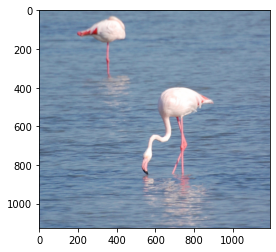

In [56]:
img = plt.imread('data/book_images/flamingo.jpg')
plt.imshow(img)

In [57]:
num_images = len(image_names)
x = np.zeros((num_images, 224, 224, 3))

for i in range(num_images):
    img_path = image_dir + image_names[i]
    img = load_img(img_path, target_size=(224, 224))
    x[i] = img_to_array(img)

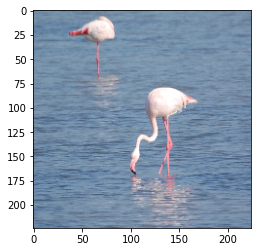

In [58]:
plt.imshow(x[0] / 255)

In [59]:
x = preprocess_input(x)

In [60]:
model = ResNet50()

102967424/102967424 [==============================] - 1s 0us/step


In [61]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [62]:
pred = model.predict(x)

1/1 [==============================] - 2s 2s/step


In [63]:
decode_predictions(pred, top=3)

35363/35363 [==============================] - 0s 0us/step


[[('n02007558', 'flamingo', 0.9301091),
  ('n02006656', 'spoonbill', 0.06801472),
  ('n02002556', 'white_stork', 0.0011723759)],
 [('n01843065', 'jacamar', 0.4865981),
  ('n01818515', 'macaw', 0.23028953),
  ('n02494079', 'squirrel_monkey', 0.044571042)],
 [('n02105641', 'Old_English_sheepdog', 0.839002),
  ('n02086240', 'Shih-Tzu', 0.042358223),
  ('n03223299', 'doormat', 0.03226598)],
 [('n03388043', 'fountain', 0.27721673),
  ('n03532672', 'hook', 0.17947067),
  ('n03804744', 'nail', 0.110358305)],
 [('n02097474', 'Tibetan_terrier', 0.5246218),
  ('n02098413', 'Lhasa', 0.40590072),
  ('n02094114', 'Norfolk_terrier', 0.016995346)],
 [('n01608432', 'kite', 0.72434276),
  ('n01622779', 'great_grey_owl', 0.08683509),
  ('n01532829', 'house_finch', 0.039976243)]]

# 5. IMDb Document Classification

In [64]:
from tensorflow.keras.datasets.imdb import load_data, get_word_index

In [65]:
max_features = 10000
(X_train, y_train), (X_test, y_test) = load_data(num_words=max_features)

17464789/17464789 [==============================] - 0s 0us/step


In [66]:
X_train.shape

(25000,)

In [67]:
y_train.shape

(25000,)

In [68]:
X_test.shape

(25000,)

In [69]:
np.unique(y_train)

array([0, 1])

In [70]:
X_train[0][:12]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468]

In [71]:
word_index = get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


In [72]:
def decode_review(text, word_index):
    word = list(word_index.keys())
    idx = np.array(list(word_index.values()))
    word = np.r_[['<PAD>', '<START>', '<UNK>', '<UNUSED>'], word].tolist()
    idx = np.r_[[0, 1, 2, 3], idx + 3].tolist()
    word_dict = dict(zip(idx, word))
    words = [word_dict[i] if i in idx else word_dict[1] for i in text]
    return ' '.join(words)

In [73]:
decode_review(X_train[0][:12], word_index)

"<START> this film was just brilliant casting location scenery story direction everyone's"

In [74]:
from scipy.sparse import coo_matrix
from itertools import chain

In [75]:
def one_hot(sequences, dimension):
    seqlen = [len(seq) for seq in sequences]
    n = len(seqlen)
    row_index = np.repeat(range(n), seqlen)
    col_index = list(chain.from_iterable(sequences))
    values = np.ones(len(row_index))
    return coo_matrix((values, (row_index, col_index)), shape=[n, dimension])

In [76]:
X_train_1h = one_hot(X_train, 10000)
X_test_1h = one_hot(X_test, 10000)

In [77]:
X_train_1h.shape

(25000, 10000)

In [78]:
X_train_1h.nnz / (25000 * 10000)

0.023871364

In [79]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import ShuffleSplit

In [80]:
model = LogisticRegressionCV(
    cv=ShuffleSplit(n_splits=1, random_state=3, test_size=2000),
    penalty='l1', solver='liblinear'
).fit(X_train_1h, y_train)

In [81]:
(model.predict(X_test_1h) == y_test).mean()

0.87876

In [82]:
model = Sequential([
    Dense(units=16, activation='relu', input_shape=(10000,)),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', metrics=['accuracy', ])

history_model = model.fit(
    X_train_1h.toarray(), y_train, epochs=20, batch_size=512,
    validation_data=(X_test_1h.toarray(), y_test), verbose=0
)

In [83]:
_, acc = model.evaluate(X_test_1h.toarray(), y_test)
acc

782/782 [==============================] - 2s 3ms/step - loss: 0.6844 - accuracy: 0.8499


0.8499199748039246

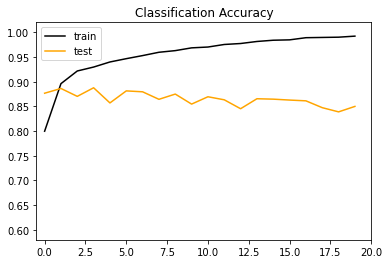

In [84]:
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.ylim(0.58, 1.02)
plt.xlim(-0.5, 20)
plt.show()

# 6. Recurrent Neural Networks

## Sequential Models for Document Classification

In [85]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Input

In [86]:
wc = np.array([len(doc) for doc in X_train])

In [87]:
np.median(wc)

178.0

In [88]:
(wc <= 500).mean()

0.91568

In [89]:
max_len = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)

In [90]:
X_train.shape

(25000, 500)

In [91]:
X_test.shape

(25000, 500)

In [92]:
X_train[0, 489:500]

array([  16, 4472,  113,  103,   32,   15,   16, 5345,   19,  178,   32],
      dtype=int32)

In [94]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=32),
    LSTM(units=32),
    Dense(units=1, activation='sigmoid')
])

In [95]:
model.compile(loss='binary_crossentropy', metrics=['acc', ])

In [96]:
history_model = model.fit(X_train, y_train, batch_size=128, epochs=10,
                          validation_data=(X_test, y_test), verbose=0)

In [99]:
preds = model.predict(X_test) > 0.5

782/782 [==============================] - 7s 9ms/step


In [104]:
(y_test == preds.squeeze()).mean()

0.8572

In [105]:
history_dict = history.history

In [108]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

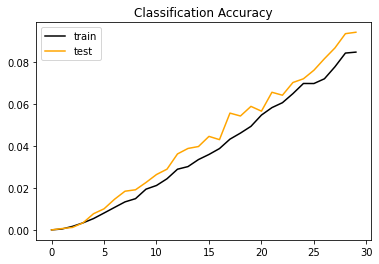

In [109]:
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

## Time Series Prediction

__Sorry but I can't get the data__